# Imports and Data

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import datetime as dt
import os
import matplotlib.pyplot as plt
import phonecalls as pc
import scipy.stats as stats
import scipy.interpolate as interpol
import statsmodels.api as sm
import time
import copy
import math
import pickle


plt.rcParams['figure.figsize'] = (20, 10)
markers = ['o', 'v', 's', 'P', '*', 'X', 'd', 'x', 'D', '2', '+']
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

with open('unfiltered.pkl', 'rb') as handle:
    unfiltered = pickle.load(handle)
handle.close()

with open('../itdata/mtl_dffa15.pickle', 'rb') as handle:
    itdffa15 = pickle.load(handle)
    handle.close()
    
with open('../itdata/mtl_dffa30.pickle', 'rb') as handle:
    itdffa30 = pickle.load(handle)
    handle.close()
    
with open('../itdata/mtl_livesd.pickle', 'rb') as handle:
    itlives = pickle.load(handle)
    handle.close()
    
calls = {}
for c in ['uk', 'uk2', 'mit']:
    calls[c] = pc.apply_filters(unfiltered[c], 60)

globalt0 = dt.datetime.now()

# SI for PNAS

## Fig 1 with different values of $\Delta t_w$

Using the same lifetime groups as Fig 1 from the paper

In [2]:
10 in itlives[60].keys()

False

In [3]:
limits = {}
limits['uk'] = [(0, 50), (80, 130), (220, 270)]
limits['uk2'] = [(0, 50), (100, 150), (220, 270)]
limits['it'] = [(0, 50), (210, 260), (320, 370)]
limits['mit'] = [(0, 50), (100, 150), (210, 260)]

In [4]:
t0 = dt.datetime.now()
S1 = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    S1[c] = {}
    if c == 'it':
        for Dt in itdffa15.keys():
            S1[c][Dt] = {}
            dff = itdffa15[Dt]
            for lamb in range(3):
                S1[c][Dt][lamb] = {'f': pc.get_avgfa(dff, itlives[Dt], limits[c][lamb][0], limits[c][lamb][1])}
    else:
        for Dt in itdffa15.keys():
            S1[c][Dt] = {}
            df = pc.apply_filters(unfiltered[c], Dt)
            for lamb in range(3):
                S1[c][Dt][lamb] = pc.get_fal(df, limits[c][lamb][0], limits[c][lamb][1], 15)
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:10.751281


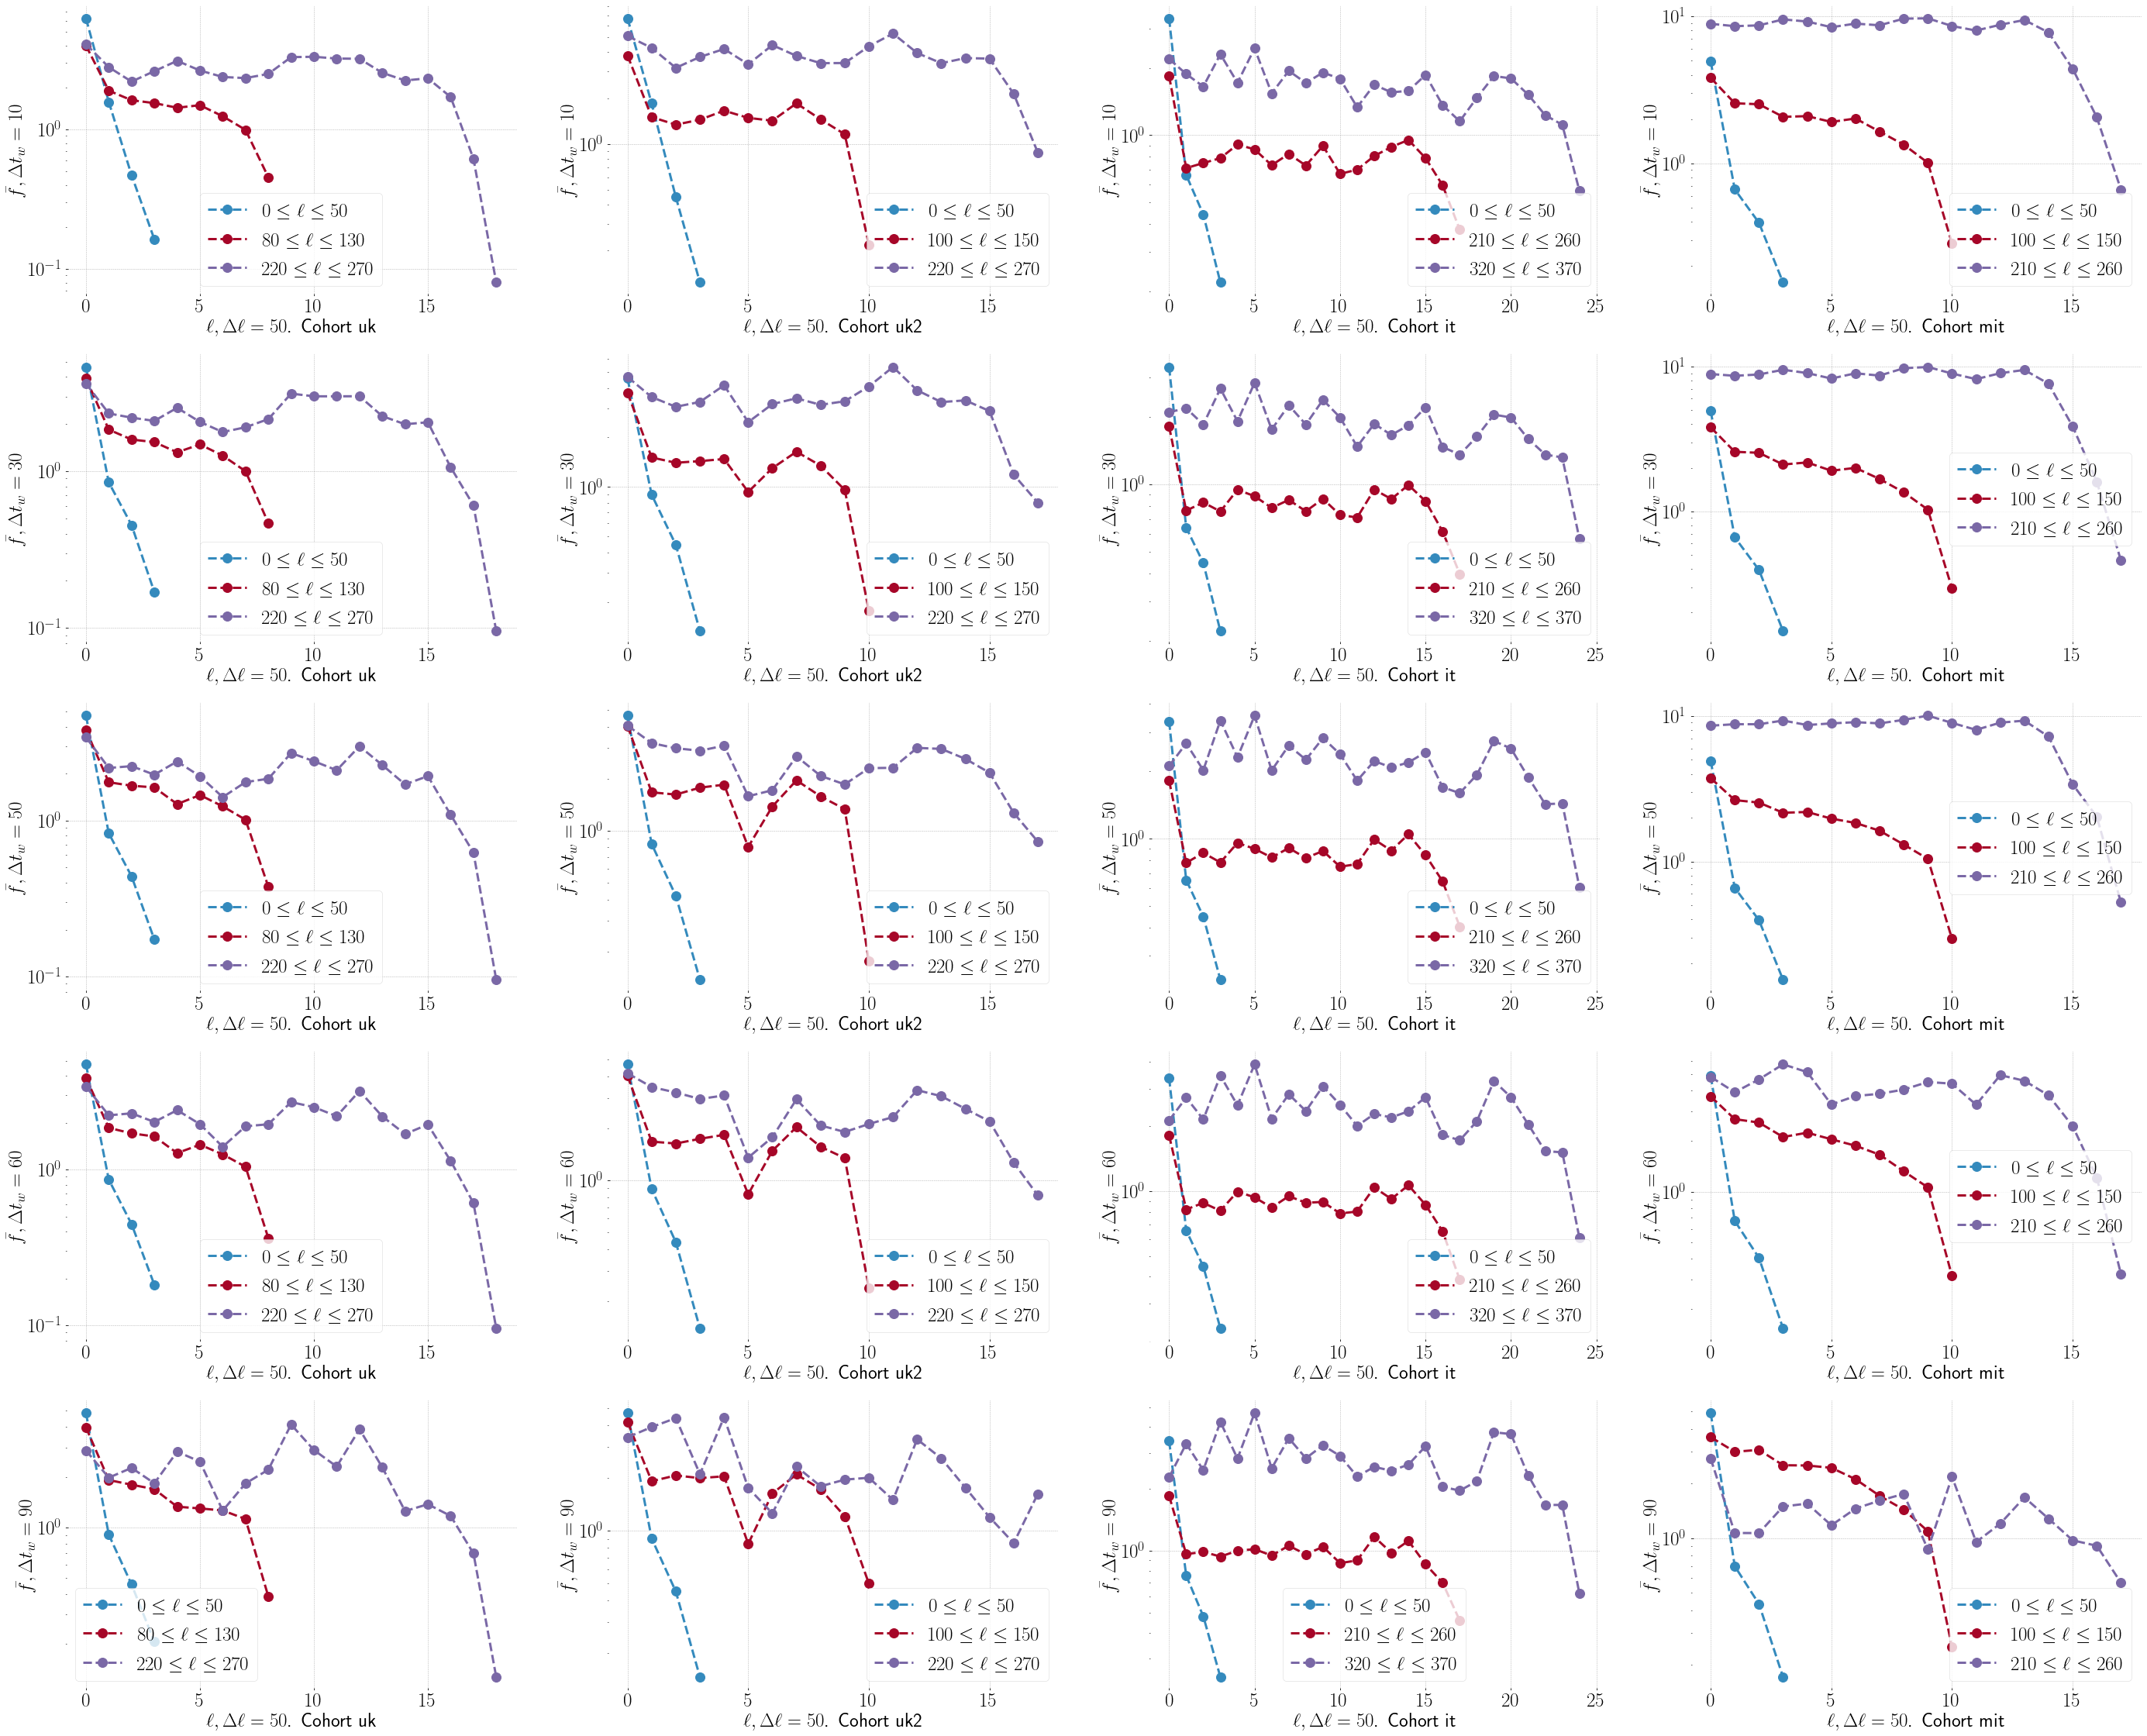

In [5]:
plt.figure(figsize=(12*4, 8*5))
p = 1
for Dt in S1['uk'].keys():
    for c in S1.keys():
        plt.subplot(5, 4, p)
        plt.xlabel(fr"$\ell, \Delta \ell = 50$. Cohort {c}")
        plt.ylabel(fr'$\bar{{f}}, \Delta t_w = {Dt}$')
        plt.semilogy()
        for lamb in range(3):
            plt.plot(S1[c][Dt][lamb]['f'].index, S1[c][Dt][lamb]['f']['f'], marker="o", markersize=12, ls="dashed", lw=3, label=fr'${limits[c][lamb][0]}\leq \ell \leq {limits[c][lamb][1]}$')
        plt.legend()
        p += 1

In [6]:
tmp = pd.DataFrame(index=list(range(25)))
for c in S1.keys():
    for Dt in S1[c].keys():
        for i in range(3):
            idx = list(S1[c][Dt][i]['f'].index)
            series = list(S1[c][Dt][i]['f']['f'])
            colname = f'{c}{Dt}{["s", "m", "l"][i]}'
            df = pd.DataFrame({colname: series}, index=idx)
            tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
tmp = tmp.fillna('nan')
tmp.index.rename('a', inplace=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/S1.dat", header=True, index=True, sep="\t")

In [7]:
S1['uk'].keys()

dict_keys([10, 30, 50, 60, 90])

## S2: Fig 1 with different values for $\Delta \ell$

In [8]:
limits = {}
limits['uk'] = [(0, 50), (80, 130), (220, 270)]
limits['uk2'] = [(0, 50), (100, 150), (220, 270)]
limits['it'] = [(0, 50), (210, 260), (320, 370)]
limits['mit'] = [(0, 50), (100, 150), (210, 260)]

In [9]:
lims = {}
for c in limits.keys():
    lims[c] = {}
    for i in range(3):
        lims[c][i] = [limits[c][i]] + [(limits[c][i][0], limits[c][i][0] + Dl) for Dl in [10, 30, 70, 90]]

In [10]:
S2 = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    S2[c] = {}
    for i in range(3):
        S2[c][i] = {}
        for j in range(5):
            if c == 'it':
                S2[c][i][j] = {'f': pc.get_avgfa(itdffa15[60], itlives[60], lims[c][i][j][0], lims[c][i][j][1])}
            else:
                S2[c][i][j] = pc.get_fal(calls[c], lims[c][i][j][0], lims[c][i][j][1], 15)

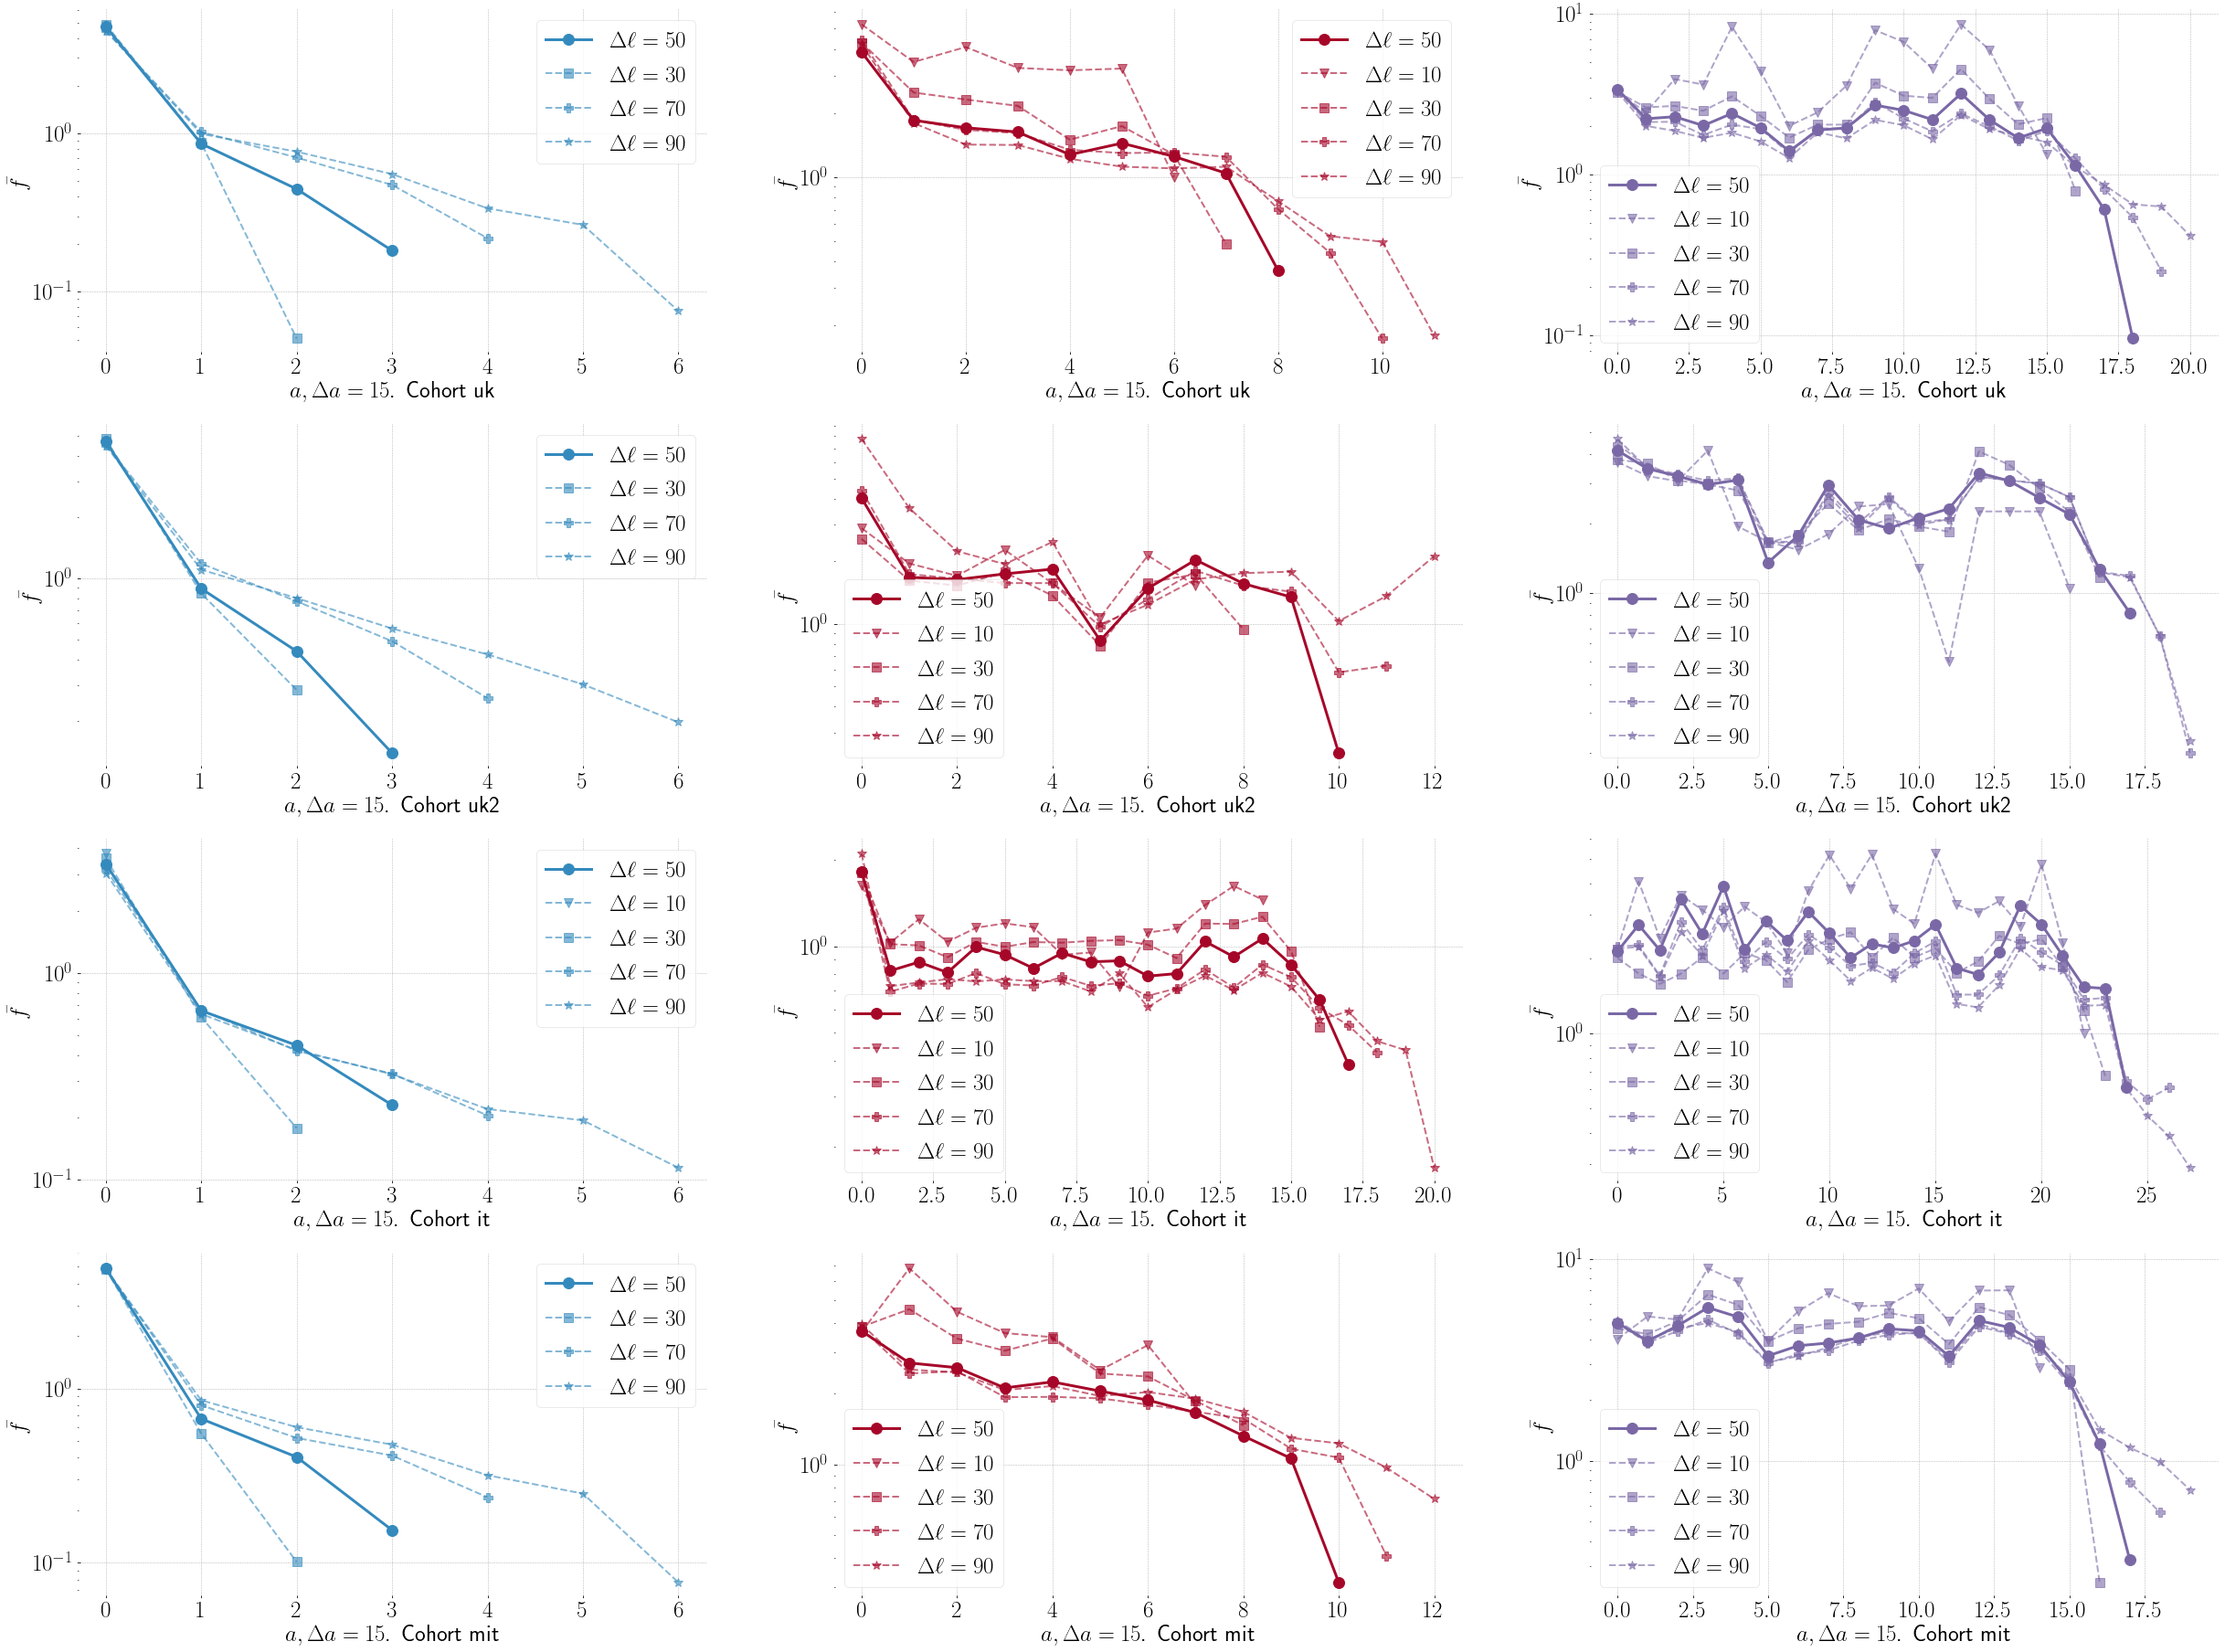

In [11]:
plt.figure(figsize=(14*3, 8*4))
p = 1
for c in S2.keys():
    for lg in S2[c].keys():
        plt.subplot(4, 3, p)
        plt.xlabel(fr"$a, \Delta a  = 15$. Cohort {c}")
        plt.ylabel(r"$\bar{f}$")
        plt.semilogy()
        plt.plot(S2[c][lg][0]['f'].index, S2[c][lg][0]['f']['f'], marker="o", markersize=12, ls="solid", lw=3, c=colors[lg], label=r'$\Delta \ell = 50$')
        for i in range(1, 5):
            if S2[c][lg][i] is not None:
                plt.plot(S2[c][lg][i]['f'].index, S2[c][lg][i]['f']['f'], marker=markers[i], markersize=10, ls="dashed", lw=2, c=colors[lg], alpha=0.6, label=fr'$\Delta \ell = {[10, 30, 70, 90][i - 1]}$')
        plt.legend()
        p += 1

In [12]:
tmp = pd.DataFrame(index=list(range(28)))
for c in S2.keys():
    for lg in S2[c].keys():
        for i in range(5):
            df = S2[c][lg][i]
            if df is not None:
                df = df['f']
                colname = f'{c}{["s", "m", "l"][lg]}{i}'
                series = list(df['f'])
                df2 = pd.DataFrame({colname: series}, index=df.index)
                tmp = tmp.merge(df2, left_index=True, right_index=True, how='outer')
            else:
                colname = f'{c}{["s", "m", "l"][lg]}{i}'
                df2 = pd.DataFrame({colname: [np.nan  for x in range(28)]}, index=tmp.index)
                tmp = tmp.merge(df2, left_index=True, right_index=True, how='outer')
tmp = tmp.fillna('nan')
tmp.index.rename('a', inplace=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/S2.dat", header=True, index=True, sep="\t")

## $\bar{f}$ with a random sample of $\bar{f_{i}}$
For all cohorts

In [13]:
limits = {}
limits['uk'] = [(0, 50), (80, 130), (220, 270)]
limits['uk2'] = [(0, 50), (100, 150), (220, 270)]
limits['it'] = [(0, 50), (210, 260), (320, 370)]
limits['mit'] = [(0, 50), (100, 150), (210, 260)]

fig1 = {}
for c in ['uk', 'uk2', 'mit']:
    fig1[c] = {}
    for i in range(3):
        fig1[c][i] = pc.get_fal(calls[c], limits[c][i][0], limits[c][i][1], 15)
        
fig1['it'] = {}
for i in range(3):
    fig1['it'][i] = {}
    fig1['it'][i]['f'] = pc.get_avgfa(itdffa15[60], itlives[60], limits['it'][i][0], limits['it'][i][1])
    fig1['it'][i]['fi'] = {}
    for ego in itdffa15[60].keys():
        tmp = {ego: itdffa15[60][ego]}
        fig1['it'][i]['fi'][ego] = pc.get_avgfa(tmp, itlives[60], limits['it'][i][0], limits['it'][i][1])
        
dashed = {}
for c in ['uk', 'uk2', 'it', 'mit']:
    dashed[c] = {}
    print(f'======================={c}=====================')
    for lamb in fig1[c].keys():
        if lamb >= 0:
#             points = pc.get_plateau(fig1[c][lamb]['f'], pstar=0.01)
            points = pc.get_b_slopes(fig1[c][lamb]['f'])
#             dashed[c][lamb] = [[x[0] for x in points], [y[1] for y in points]]
            dashed[c][lamb] = points
            print(f'\draw[dashed, {["charmander", "squirtle", "ekans"][lamb]}, ultra thick] (axis cs: {points[0][0]}, {points[1][0]}) -- (axis cs: {points[0][1]}, {points[1][1]});')

=======================uk=====================
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.654265084574468) -- (axis cs: 2, 0.654265084574468);
\draw[dashed, squirtle, ultra thick] (axis cs: 1, 1.4581887315198958) -- (axis cs: 7, 1.4581887315198958);
\draw[dashed, ekans, ultra thick] (axis cs: 5, 2.2256547446074486) -- (axis cs: 13, 2.2256547446074486);
=======================uk2=====================
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.6647318258067262) -- (axis cs: 2, 0.6647318258067262);
\draw[dashed, squirtle, ultra thick] (axis cs: 2, 1.5923360902462018) -- (axis cs: 7, 1.5923360902462018);
\draw[dashed, ekans, ultra thick] (axis cs: 3, 2.450963957437888) -- (axis cs: 13, 2.450963957437888);
=======================it=====================
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.551795638030544) -- (axis cs: 2, 0.551795638030544);
\draw[dashed, squirtle, ultra thick] (axis cs: 1, 0.8991669257367098) -- (axis cs: 15, 0.8991669257367098);
\draw

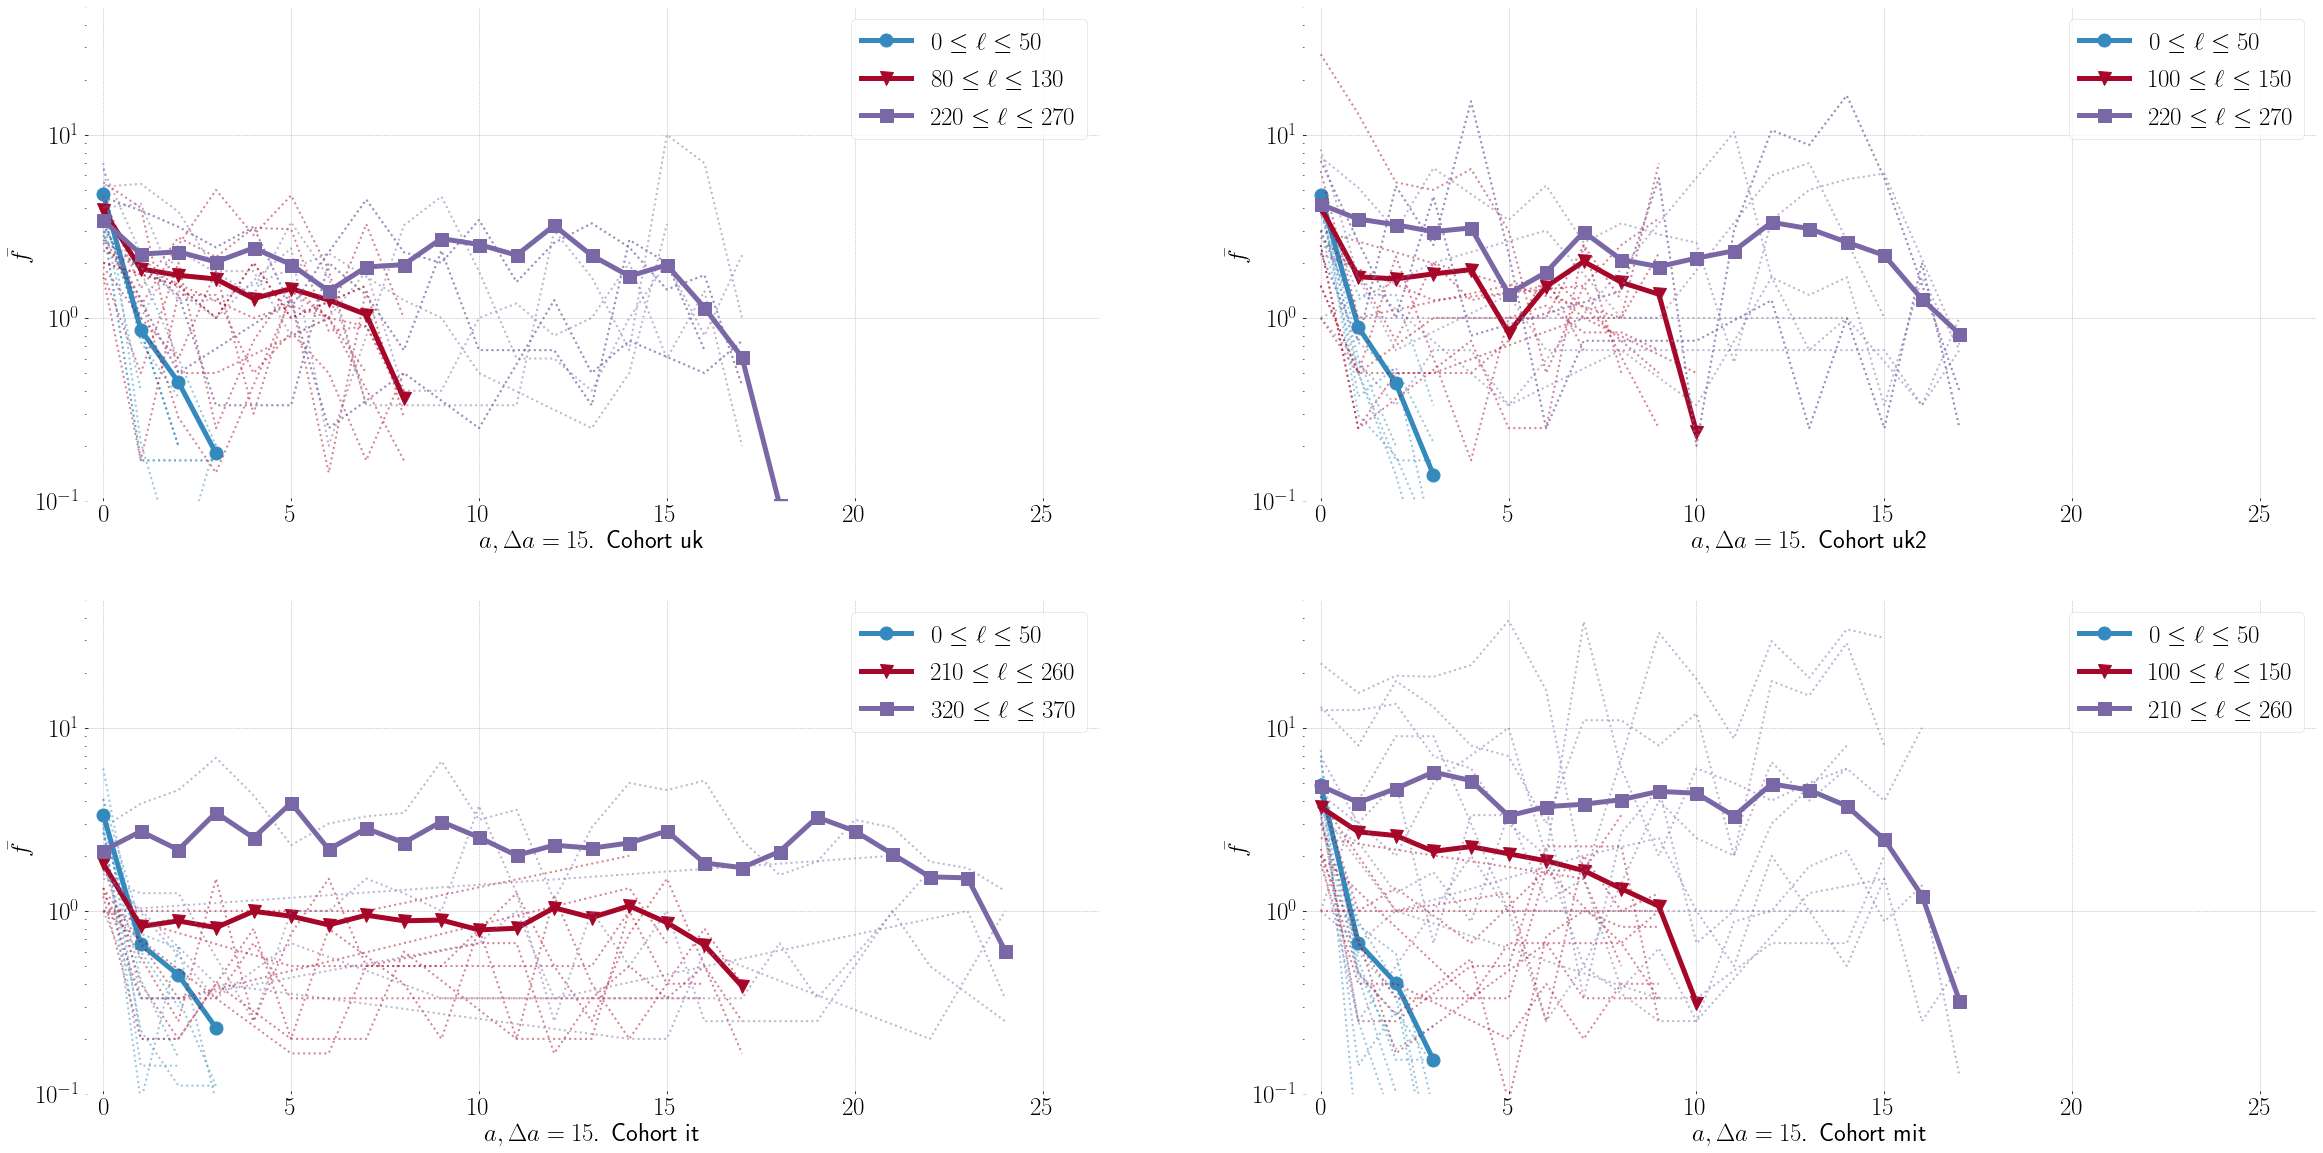

In [14]:
np.random.seed(2)
tmp = pd.DataFrame(index=range(25))
plt.figure(figsize=(20*2, 10*2))
p = 1
for c in ['uk', 'uk2', 'it', 'mit']:
    plt.subplot(2, 2, p)
    plt.ylim(10**(-1), 5*10**1)
    plt.semilogy()
    plt.xlim(-0.5, 26.5)
    plt.xlabel(fr'$a, \Delta a  = 15$. Cohort {c}')
    plt.ylabel(r'$\bar{f}$')
    for i in range(3):
        plt.plot(fig1[c][i]['f'].index, fig1[c][i]['f']['f'], marker=markers[i], ls="solid", lw=5, markersize=13, c=colors[i], label=fr'${limits[c][i][0]}\leq \ell \leq {limits[c][i][1]}$')
        df = fig1[c][i]['f'].copy(deep=True)
        df.columns = [f'{c}{i}avg']
        tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
        egos = np.random.choice(list(fig1[c][i]['fi'].keys()), size=10)
        en = 1
        for e in egos:
            plt.plot(fig1[c][i]['fi'][e].index, fig1[c][i]['fi'][e]['f'], marker="", ls="dotted", lw=2, c=colors[i], alpha=0.5)
            df = fig1[c][i]['fi'][e].copy(deep=True)
            df.columns = [f'{c}{i}e{en}']
            tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
            en += 1
    plt.legend()
    p += 1
# plt.savefig("../commpatterns/PNAS_paper/SI/figs/SA.pdf", dpi=200)

In [15]:
tmp = tmp.fillna('nan')
tmp.index.rename('a', inplace=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/S3.dat", header=True, index=True, sep="\t")

# Attempt to scale fig 3

In [21]:
dff30 = {}
dff30['all'] = {}
for c in calls.keys():
    dff30[c] = pc.get_f(calls[c], 'all', 30, 10)
    dff30['all'].update(dff30[c])
    
dff30['it'] = itdffa30[60]
dff30['all'].update(dff30['it'])

In [17]:
lives = {}
lives['all'] = {}
for c in ['uk', 'uk2', 'mit']:
    lives[c] = pc.lives_dictionary(calls[c])
    lives['all'].update(lives[c])
lives['it'] = itlives[60]
lives['all'].update(lives['it'])

In [24]:
survival = {}
for c in dff30.keys():
    survival[c] = pc.get_survival(dff30[c], lambdamax=25)

In [26]:
t0 = dt.datetime.now()
b = {}
converge = {}
for ell in range(251):
    curve = pc.get_avgfa(dff30['all'], lives['all'], ell, ell + 50)
    if len(curve) > 2:
        points = pc.get_b_slopes(curve, FlagConverge=True)
        b[ell] = points[1][1]
        converge[ell] = points[2]
b = pd.DataFrame.from_dict(b, orient='index').sort_index().rename({0: 'b'}, axis='columns')
tmp = pd.DataFrame.from_dict(converge, orient="index").sort_index().rename({0: 'converge'}, axis='columns')
b = b.merge(tmp, left_index=True, right_index=True, how='outer')
b['ma50'] = b['b'].rolling(window=50).mean()
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:32.581763


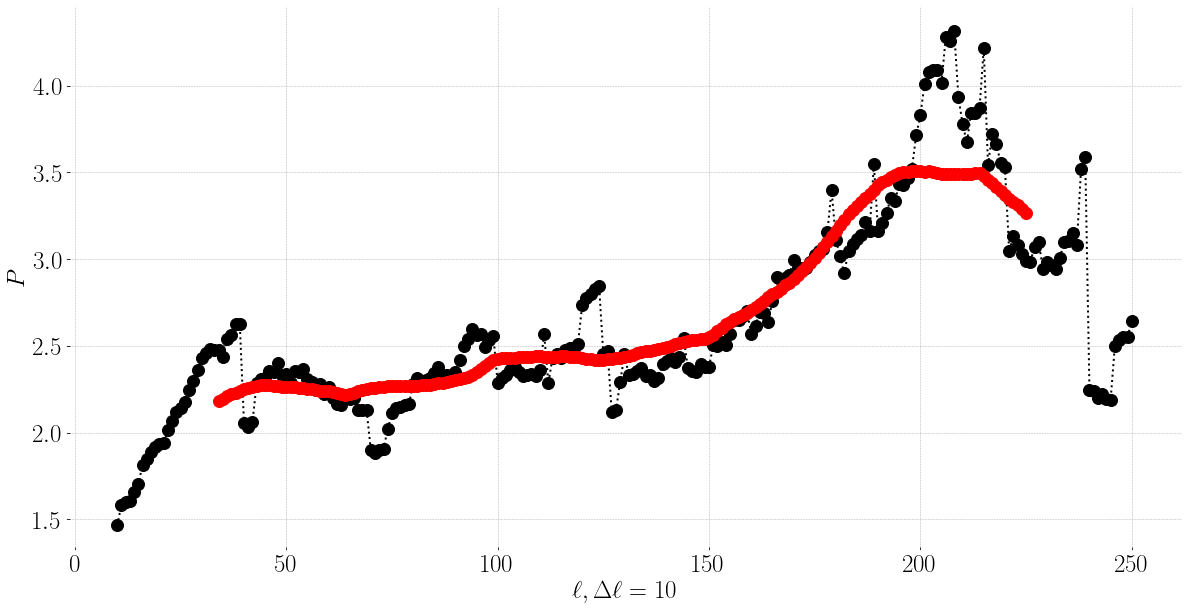

In [27]:
plt.xlabel(r'$\ell, \Delta \ell = 10$')
plt.ylabel(r'$P$')
plt.plot(b.index, b['b'], marker="o", markersize=12, ls="dotted", c="black")
plt.plot([x - 25 for x in b.index], b['ma50'], marker="o", markersize=12, ls="dotted", c="red")

In [28]:
for i in range(6):
    g = 2**(i + 1)
    print(((60 - 30)*g) / 30)

2.0
4.0
8.0
16.0
32.0
64.0


# Rolling window using Italy

and making the distinction between IT1 and IT2

In [29]:
with open('../itdata/tmp/mtl_dffa15.pickle', 'rb') as handle:
    tmpdff = pickle.load(handle)
    handle.close()
    
with open('../itdata/tmp/mtl_livesd.pickle', 'rb') as handle:
    tmplives = pickle.load(handle)
    handle.close()

In [30]:
maxa = {}
for c in calls.keys():
    maxa[c] = max(calls[c]['aclock'])
maxit = 0
for c in ['it', 'it1', 'it2']:
    if c == 'it':
        lvs = itlives[60]
    else:
        lvs = tmplives[c][60]
    for ego in lvs.keys():
        for alter in lvs[ego].keys():
            if lvs[ego][alter]['ell'] > maxit:
                maxit = lvs[ego][alter]['ell']
    maxa[c] = maxit
maxa

{'uk': 482, 'uk2': 291, 'mit': 442, 'it': 633, 'it1': 633, 'it2': 633}

In [31]:
t0 = dt.datetime.now()
b = {}
converge = {}
nalt = {}
nego = {}
for c in ['uk', 'uk2', 'it', 'mit', 'it1', 'it2']:
    b[c] = {}
    converge[c] = {}
    nalt[c] = {}
    nego[c] = {}
    for ell in range(maxa[c]):
        if c == 'it':
            tmpres = pc.get_avgfa(itdffa15[60], itlives[60], ell, ell + 50, countalt=True)
            curve  = {'f': tmpres[0]}
            tmpn = tmpres[1]
            tmpeg = tmpres[2]
        elif (c == 'it1') or (c == 'it2'):
            tmpres = pc.get_avgfa(tmpdff[c][60], tmplives[c][60], ell, ell + 50, countalt=True)
            curve = {'f': tmpres[0]}
            tmpn = tmpres[1]
            tmpeg = tmpres[2]
        else:
            curve = pc.get_fal(calls[c], ell, ell + 50, 15, countalters=True)
        if len(curve['f']) > 2:
            points = pc.get_b_slopes(curve['f'], FlagConverge=True)
            b[c][ell] = points[1][1]
            converge[c][ell] = points[2]
            if c in ['it', 'it1', 'it2']:
                nalt[c][ell] = tmpn
                nego[c][ell] = tmpeg
            else:
                nalt[c][ell] = curve['nalters']
                nego[c][ell] = curve['egocount']
    b[c] = pd.DataFrame.from_dict(b[c], orient='index').sort_index().rename({0: 'b'}, axis='columns')
    tmp = pd.DataFrame.from_dict(converge[c], orient="index").sort_index().rename({0: 'converge'}, axis='columns')
    tmp2 = pd.DataFrame.from_dict(nalt[c], orient="index").sort_index().rename({0: 'nalt'}, axis='columns')
    tmp3 = pd.DataFrame.from_dict(nego[c], orient="index").sort_index().rename({0: 'nego'}, axis='columns')
    b[c] = b[c].merge(tmp, left_index=True, right_index=True, how='outer')
    b[c] = b[c].merge(tmp2, left_index=True, right_index=True, how='outer')
    b[c] = b[c].merge(tmp3, left_index=True, right_index=True, how='outer')
    b[c]['ma50'] = b[c]['b'].rolling(window=50).mean()
print(f'Took {dt.datetime.now() - t0}')

Took 0:02:23.083286


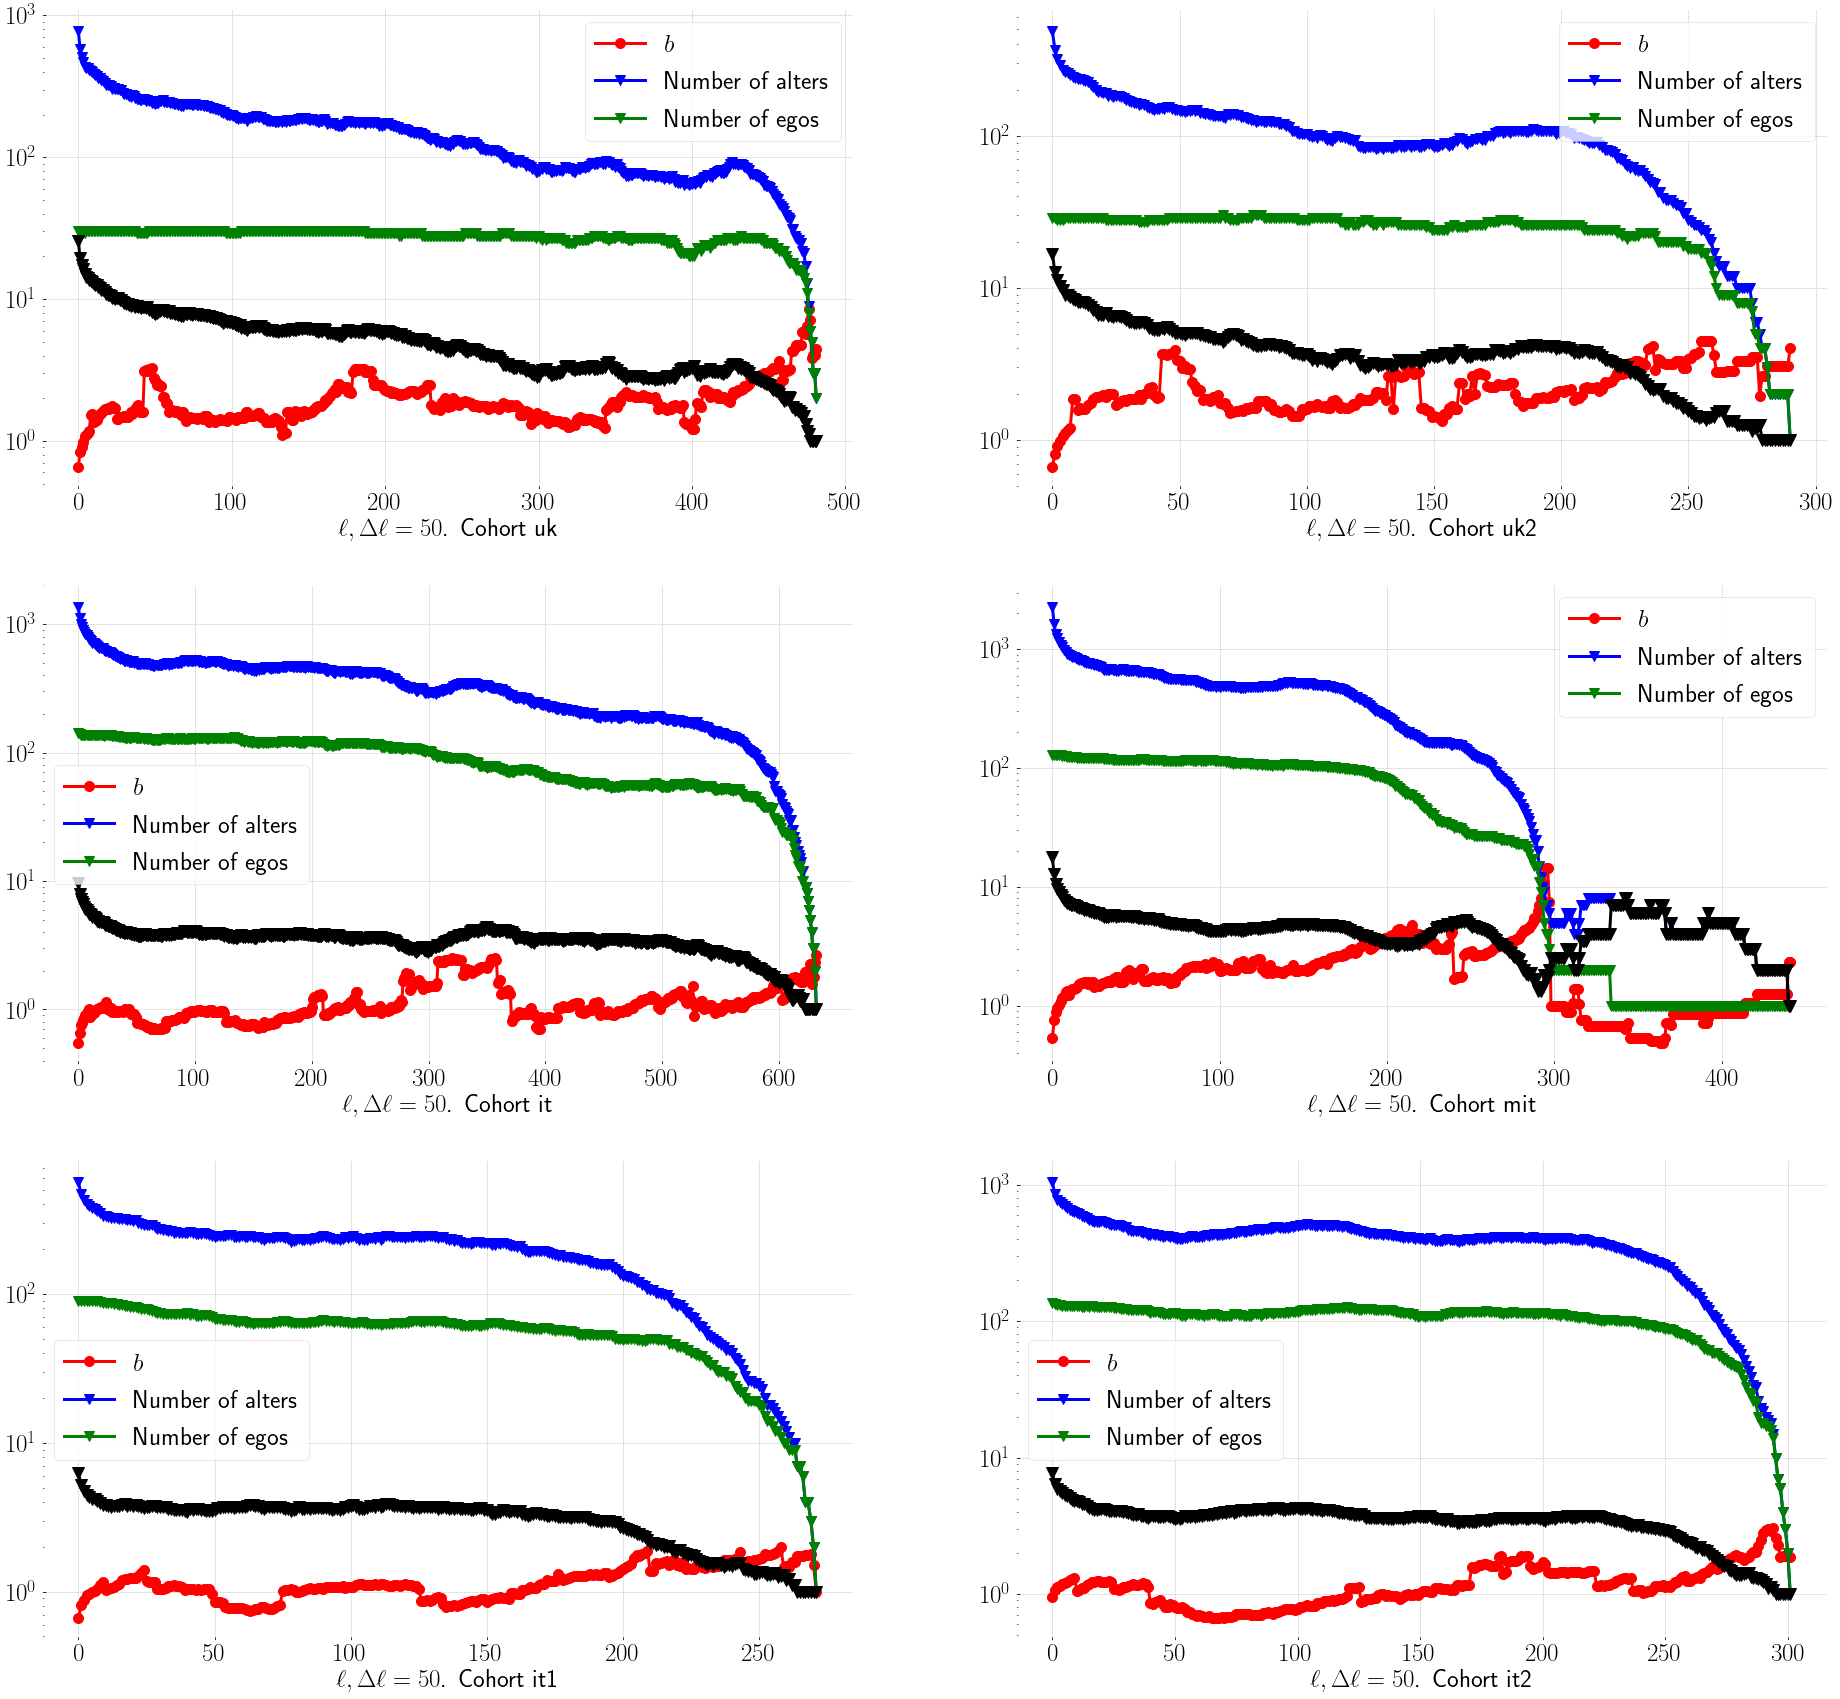

In [32]:
plt.figure(figsize=(16*2, 10*3))
p = 1
for c in b.keys():
    plt.subplot(3,2,p)
    plt.semilogy()
    plt.xlabel(fr'$\ell, \Delta \ell = 50$. Cohort {c}')
    plt.plot(b[c].index, b[c]['b'], marker=markers[0], markersize=10, ls="solid", lw=3, c="red", label=r'$b$')
    plt.plot(b[c].index, b[c]['nalt'], marker=markers[1], markersize=10, ls="solid", lw=3, c="blue", label=r'Number of alters')
    plt.plot(b[c].index, b[c]['nego'], marker=markers[1], markersize=10, ls="solid", lw=3, c="green", label=r'Number of egos')
    plt.plot(b[c].index, b[c]['nalt'] / b[c]['nego'], marker=markers[1], markersize=12, ls="solid", lw=3, c="black")
    plt.legend()
    p += 1

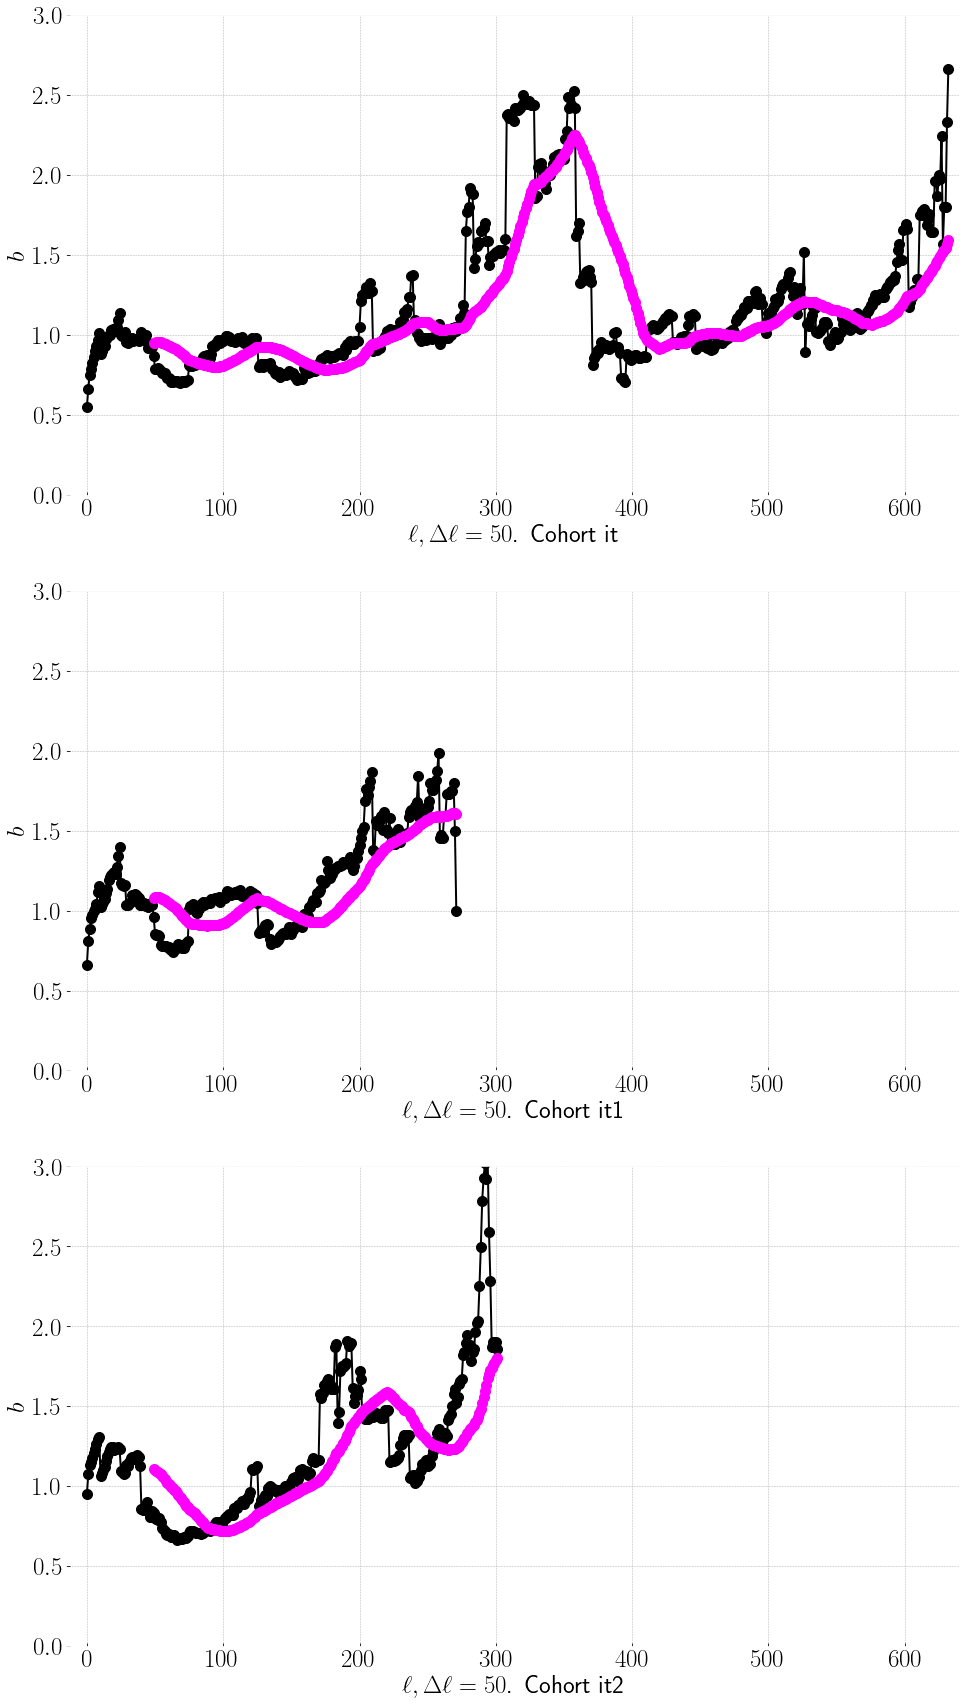

In [33]:
plt.figure(figsize=(16, 30))
p = 1
for c in ['it', 'it1', 'it2']:
    plt.subplot(3,1,p)
    plt.xlabel(fr"$\ell, \Delta \ell = 50$. Cohort {c}")
    plt.ylabel(r'$b$')
    plt.xlim(-15, 640)
    plt.ylim(0, 3)
    plt.plot(b[c].index, b[c]['b'], marker="o", markersize=10, c="black")
    plt.plot(b[c].index, b[c]['ma50'], marker="o", markersize=10, c="magenta")
    p += 1

# Fig 1 using only Italy


In [34]:
limits = {}
limits['uk'] = [(0, 50), (80, 130), (220, 270)]
limits['uk2'] = [(0, 50), (100, 150), (220, 270)]
limits['it'] = [(0, 50), (210, 260), (320, 370)]
limits['it1'] = [(0, 50), (100, 150), (210, 260)]
limits['it2'] = [(0, 50), (160, 210), (290, 340)]
limits['mit'] = [(0, 50), (100, 150), (210, 260)]

In [35]:
fig1_it = {}
for c in ['it', 'it1', 'it2']:
    fig1_it[c] = {}
    for i in range(3):
        fig1_it[c][i] = pc.get_avgfa(tmpdff[c][60], tmplives[c][60], limits[c][i][0], limits[c][i][1])

In [36]:
dashed = {}
for c in ['it', 'it1', 'it2']:
    dashed[c] = {}
    print(f'======================={c}=====================')
    for lamb in fig1_it[c].keys():
        if lamb >= 0:
#             points = pc.get_plateau(fig1_it[c][lamb], pstar=0.01)
            points = pc.get_b_slopes(fig1_it[c][lamb])
#             dashed[c][lamb] = [[x[0] for x in points], [y[1] for y in points]]
            dashed[c][lamb] = points
            print(f'\draw[dashed, {["charmander", "squirtle", "ekans"][lamb]}, ultra thick] (axis cs: {points[0][0]}, {points[1][0]}) -- (axis cs: {points[0][1]}, {points[1][1]});')

=======================it=====================
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.551795638030544) -- (axis cs: 2, 0.551795638030544);
\draw[dashed, squirtle, ultra thick] (axis cs: 1, 0.8991669257367098) -- (axis cs: 15, 0.8991669257367098);
\draw[dashed, ekans, ultra thick] (axis cs: 4, 2.5036360856719075) -- (axis cs: 20, 2.5036360856719075);
=======================it1=====================
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.6624829454614143) -- (axis cs: 2, 0.6624829454614143);
\draw[dashed, squirtle, ultra thick] (axis cs: 2, 1.079247026162641) -- (axis cs: 8, 1.079247026162641);
\draw[dashed, ekans, ultra thick] (axis cs: 2, 1.3781133288057583) -- (axis cs: 14, 1.3781133288057583);
=======================it2=====================
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.9503502544298754) -- (axis cs: 2, 0.9503502544298754);
\draw[dashed, squirtle, ultra thick] (axis cs: 3, 1.0908861301916237) -- (axis cs: 11, 1.0908861301916237);
\

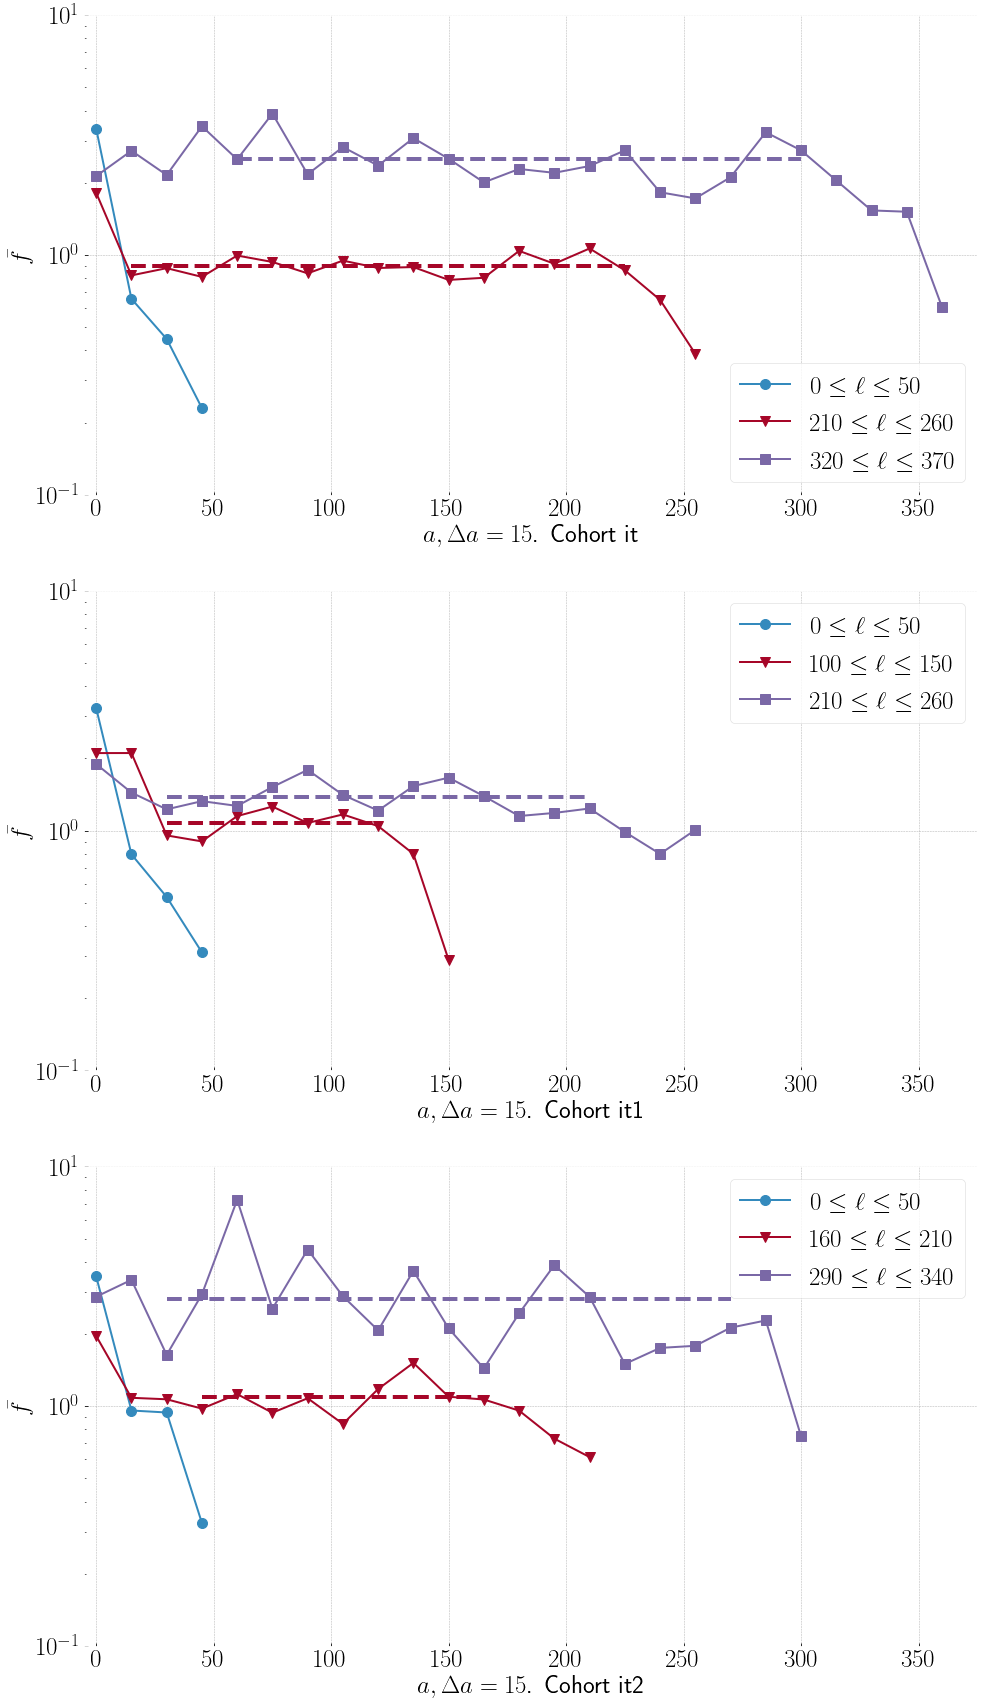

In [37]:
plt.figure(figsize=(16, 30))
p = 1
for c in fig1_it.keys():
    plt.subplot(3, 1, p)
    plt.xlabel(fr'$a, \Delta a  = 15$. Cohort {c}')
    plt.ylabel(r'$\bar{f}$')
    plt.semilogy()
    plt.xlim(-5, 375)
    plt.ylim(0.1, 10)
    for i in range(3):
        plt.plot([x * 15 for x in fig1_it[c][i].index], fig1_it[c][i]['f'], marker=markers[i], markersize=10, ls="solid", lw=2, c=colors[i], label=fr'${limits[c][i][0]} \leq \ell \leq {limits[c][i][1]}$')
        if i > 0:
            plt.plot([x * 15 for x in dashed[c][i][0]], dashed[c][i][1], marker="", ls="--", lw=4, c=colors[i])
    plt.legend()
    p += 1

# Quick result for proportion of lives and calls

For each series in Fig 1 (main paper); I have to count how many alters and how many phone calls out of the total we have **used** for the analysis

In [38]:
limits = {}
limits['uk'] = [(0, 50), (80, 130), (220, 270)]
limits['uk2'] = [(0, 50), (100, 150), (220, 270)]
limits['it'] = [(0, 50), (210, 260), (320, 370)]
limits['mit'] = [(0, 50), (100, 150), (210, 260)]

In [39]:
lives = {}
for c in ['uk', 'uk2', 'mit']:
    lives[c] = pc.lives_dictionary(calls[c])
    
lives['it'] = itlives[60]

In [40]:
counts = {}
for c in ['uk', 'uk2', 'mit', 'it']:
    counts[c] = {}
    for i in range(1, 21):
        alters = 0
        ncalls = 0
        a = 0
        cc = 0
        for ego in lives[c].keys():
            for alter in lives[c][ego].keys():
                vol = lives[c][ego][alter]['nij']
                if vol > i:
                    alters += 1
                    ncalls += vol
                    ell = lives[c][ego][alter]['ell']
                    if (ell >= limits[c][0][0] and ell <= limits[c][0][1]) or (ell >= limits[c][1][0] and ell <= limits[c][1][1]) or (ell >= limits[c][2][0] and ell <= limits[c][2][1]):
                        a += 1
                        cc += vol
            counts[c][i] = (a / alters, cc / ncalls)
    counts[c] = pd.DataFrame({'alters': [counts[c][i][0] for i in range(1, 21)], 'calls': [counts[c][i][1] for i in range(1, 21)]}, index=range(1, 21))

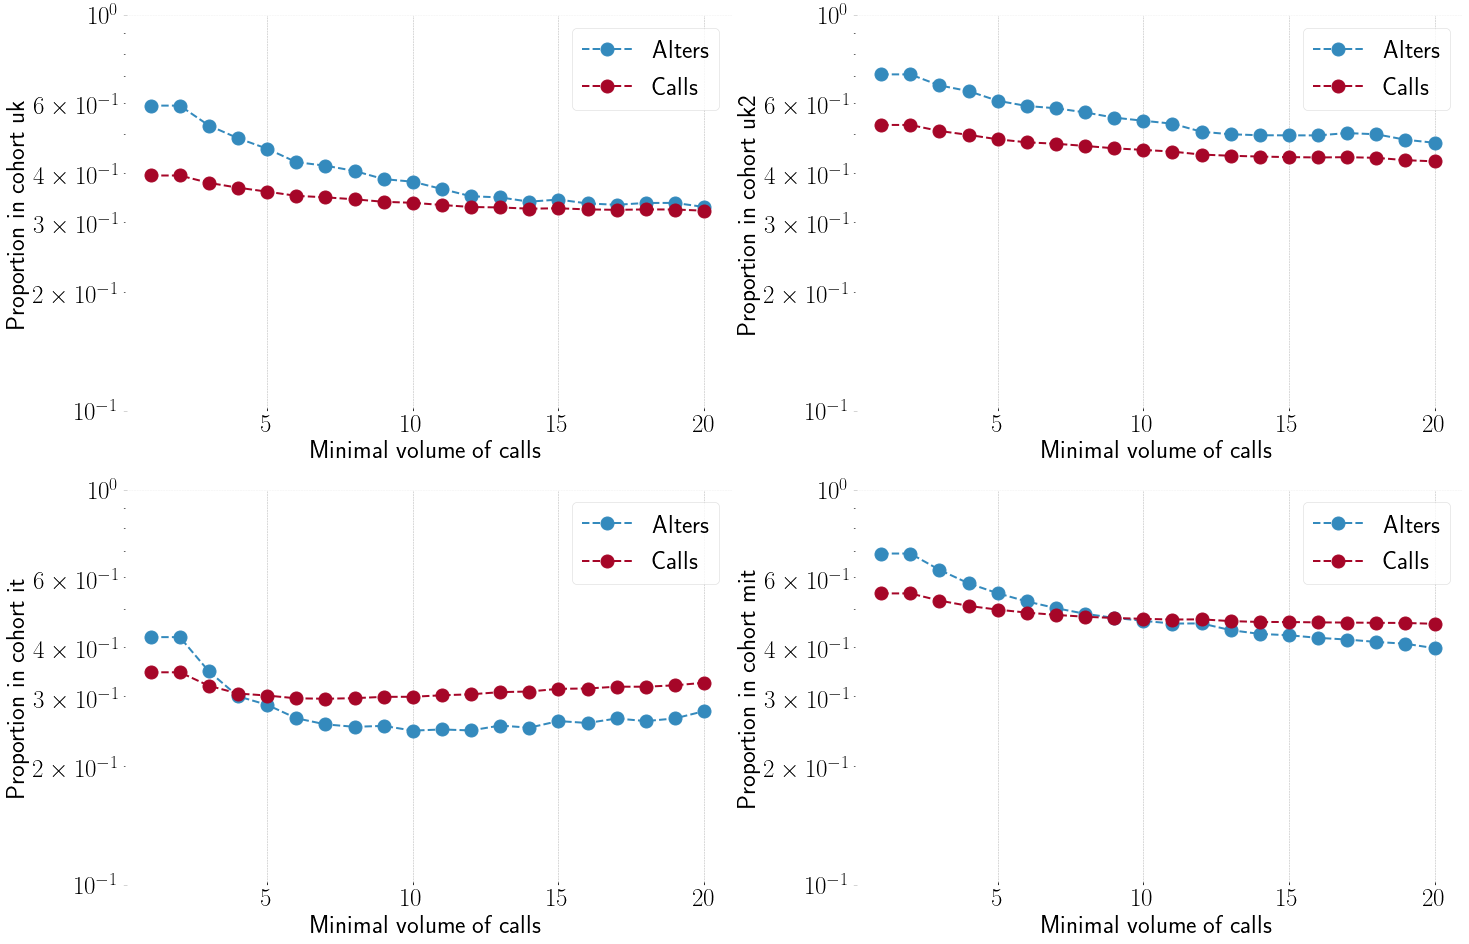

In [41]:
plt.figure(figsize=(12*2, 8*2))
p = 1
for c in ['uk', 'uk2', 'it', 'mit']:
    plt.subplot(2,2,p)
    plt.xlabel("Minimal volume of calls")
    plt.ylabel(f"Proportion in cohort {c}")
    plt.ylim(0.1, 1)
    plt.semilogy()
    plt.plot(counts[c].index, counts[c]['alters'], marker=markers[0], markersize=13, ls="--", label="Alters")
    plt.plot(counts[c].index, counts[c]['calls'], marker=markers[0], markersize=13, ls="--", label="Calls")
    plt.legend()
    p += 1

In [42]:
tmp = {}
for c in ['uk', 'uk2', 'mit']:
    tmp[c] = pc.lives_dictionary(unfiltered[c])
    
counts = {}
for c in ['uk', 'uk2', 'mit']:
    alters = 0
    ncalls = 0
    a = 0
    cc = 0
    counts[c] = {}
    for i in range(10, 301, 10):
        tmpc = pc.apply_filters(unfiltered[c], i)
        tmpl = pc.lives_dictionary(tmpc)
        for ego in tmp[c].keys():
            for alter in tmp[c][ego].keys():
                vol = tmp[c][ego][alter]['nij']
                alters += 1
                ncalls += vol
                if (ego in tmpl.keys()) and (alter in tmpl[ego].keys()):
                    a += 1
                    cc += vol
            counts[c][i] = (a / alters, cc / ncalls)
    counts[c] = pd.DataFrame({'alters': [counts[c][i][0] for i in range(10, 301, 10)], 'calls': [counts[c][i][1] for i in range(10, 301, 10)]}, index=range(10, 301, 10))

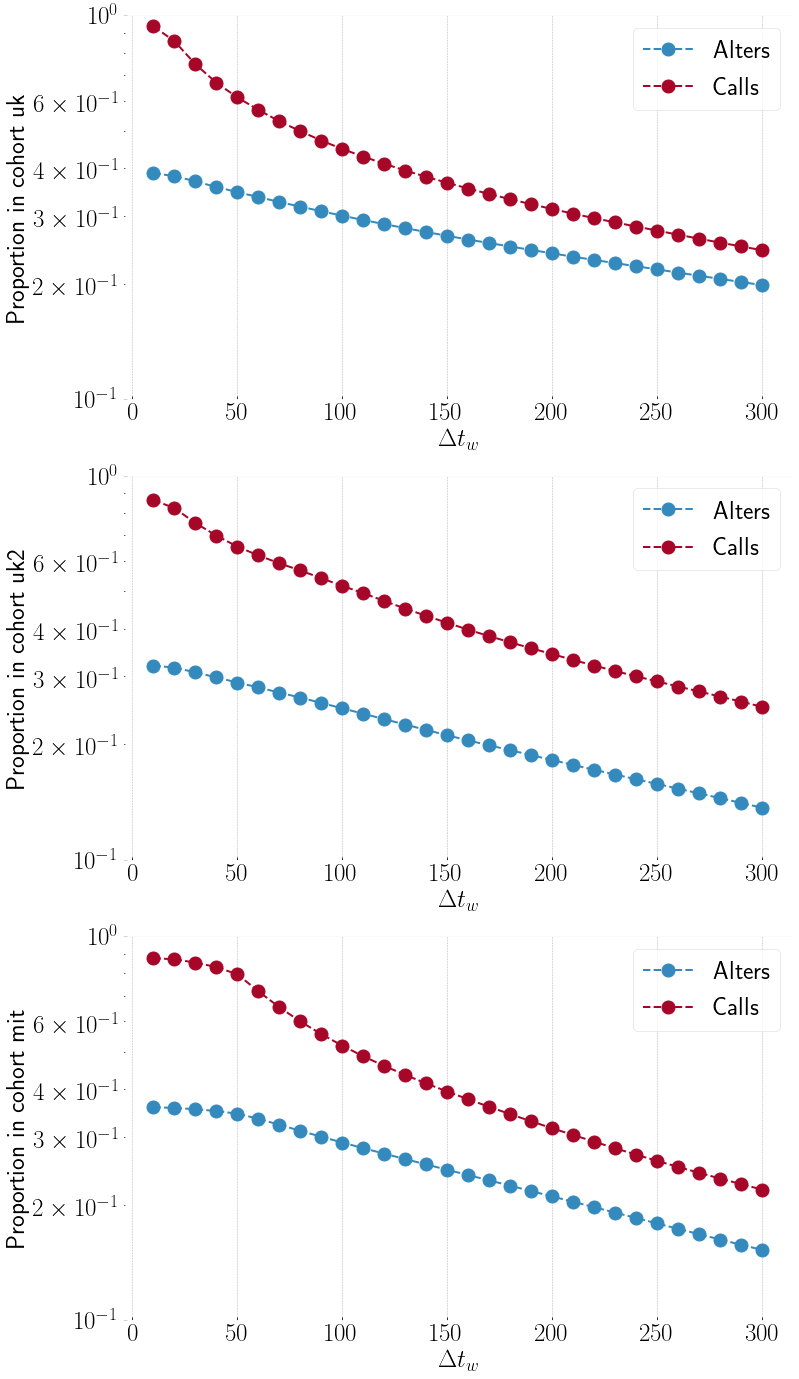

In [43]:
plt.figure(figsize=(12, 8*3))
p = 1
for c in ['uk', 'uk2', 'mit']:
    plt.subplot(3, 1, p)
    plt.xlabel(fr"$\Delta t_w$")
    plt.ylabel(f"Proportion in cohort {c}")
    plt.ylim(0.1, 1)
    plt.semilogy()
    plt.plot(counts[c].index, counts[c]['alters'], marker=markers[0], markersize=13, ls="--", label="Alters")
    plt.plot(counts[c].index, counts[c]['calls'], marker=markers[0], markersize=13, ls="--", label="Calls")
    plt.legend()
    p += 1

In [44]:
counts['uk']

alters     calls
10   0.387743  0.935951
20   0.381454  0.856805
30   0.369265  0.745690
40   0.357101  0.667560
50   0.346087  0.611082
60   0.336185  0.567395
70   0.326292  0.529469
80   0.317354  0.499171
90   0.308729  0.471783
100  0.300527  0.448460
110  0.292858  0.428533
120  0.285688  0.410375
130  0.278957  0.394169
140  0.272498  0.379468
150  0.266335  0.366111
160  0.260467  0.353751
170  0.255022  0.342316
180  0.249809  0.331810
190  0.244706  0.322018
200  0.239740  0.312856
210  0.234989  0.304199
220  0.230451  0.296150
230  0.226142  0.288701
240  0.221918  0.281642
250  0.217756  0.274871
260  0.213606  0.268136
270  0.209584  0.261798
280  0.205698  0.255710
290  0.201903  0.249968
300  0.198216  0.244319

# Change $\gamma$ in Fig 3

In [45]:
survival4 = {}
for c in dff30.keys():
    survival4[c] = pc.get_survival(dff30[c], lambdamax=25, base=4)

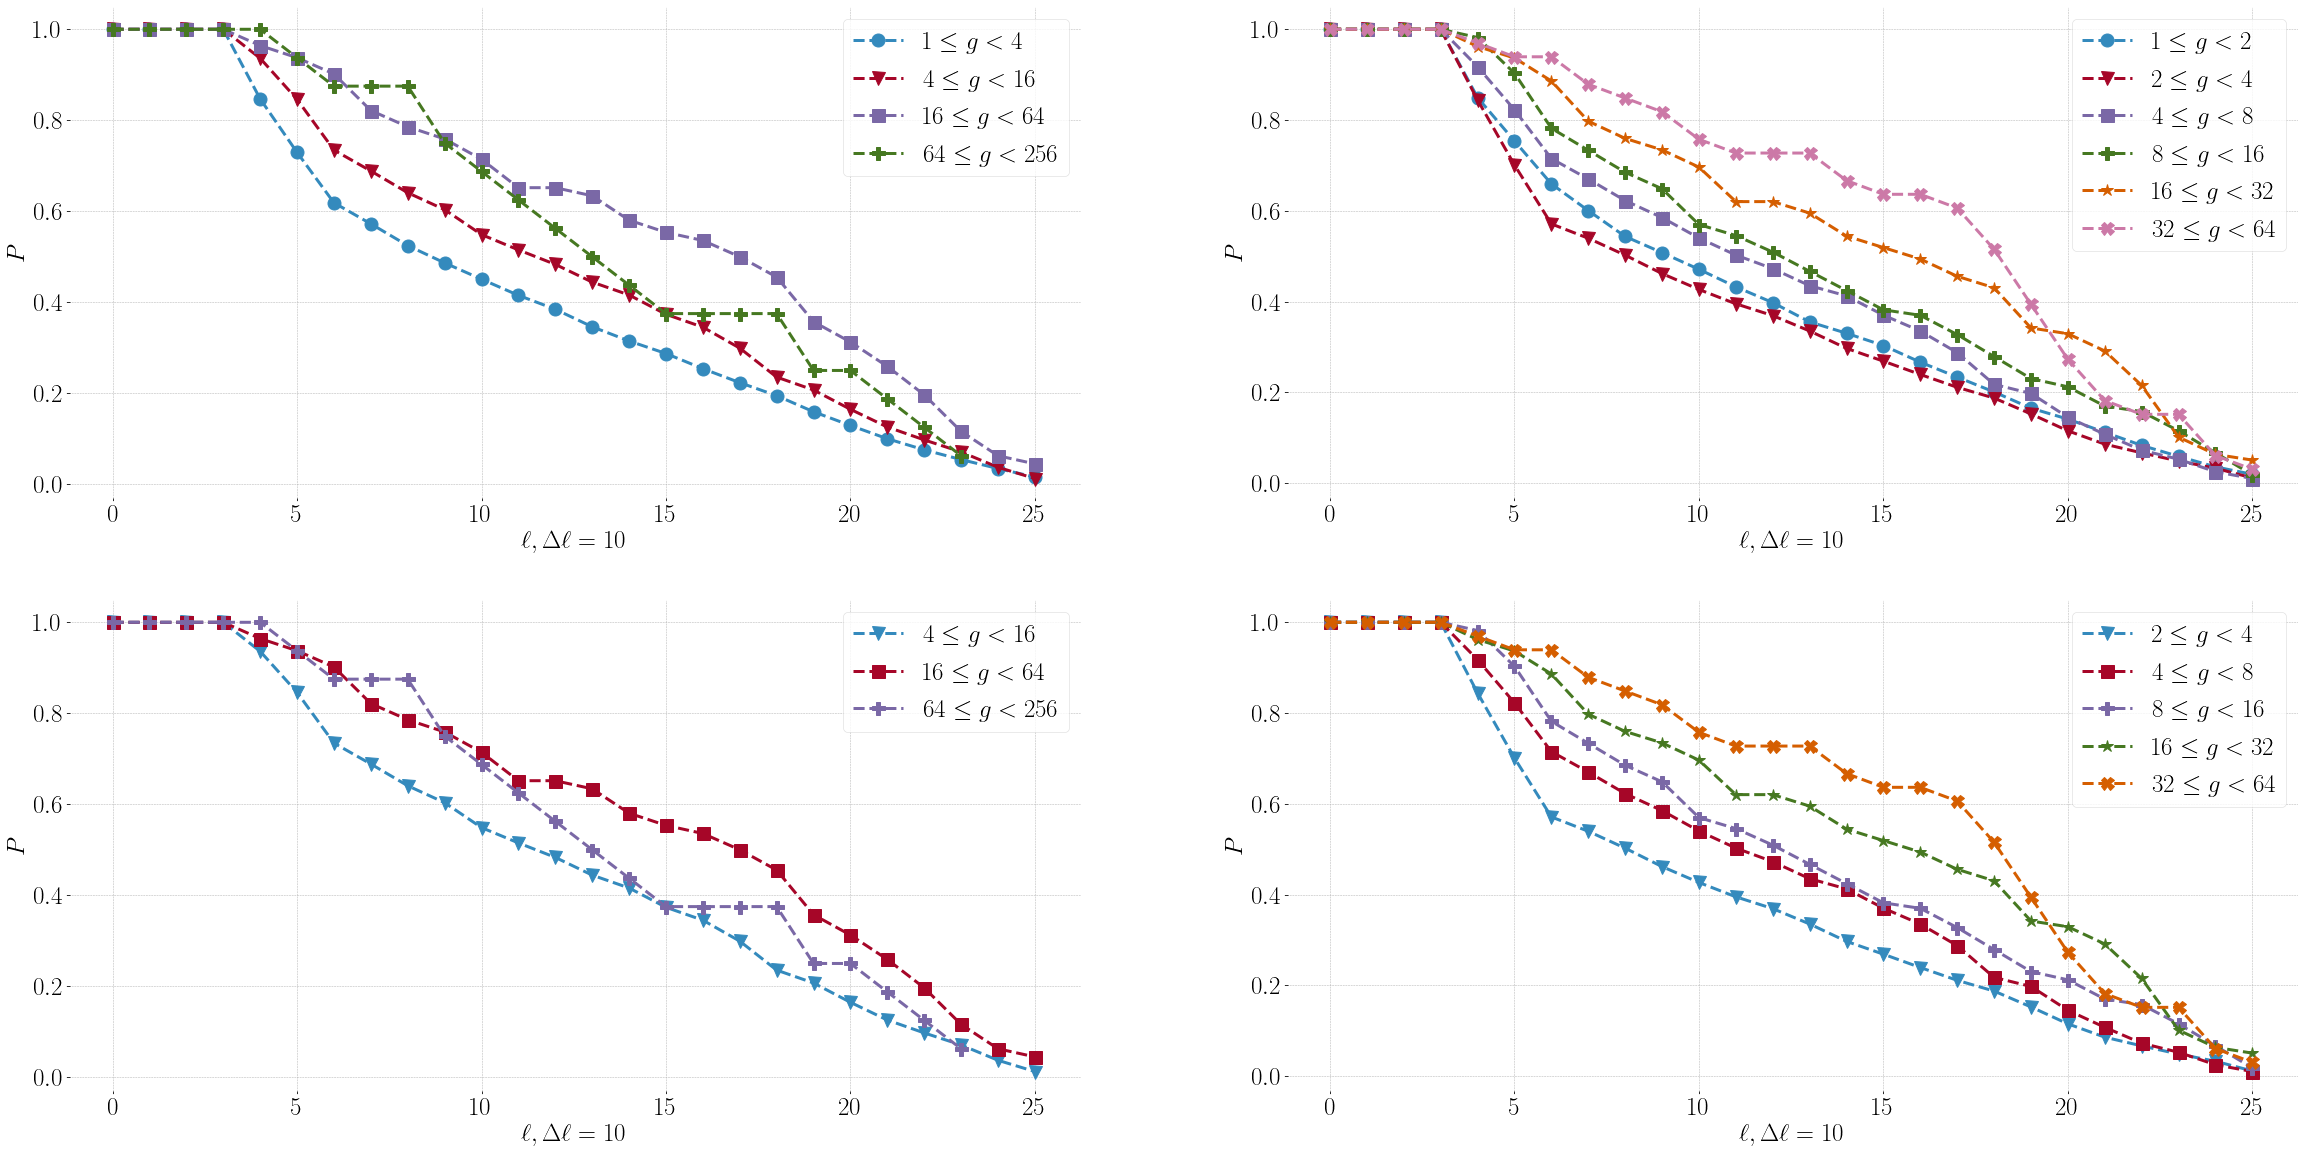

In [46]:
plt.figure(figsize=(20*2, 10*2))
plt.subplot(2,2,1)
plt.xlabel(r'$\ell, \Delta \ell = 10$')
plt.ylabel(r'$P$')
for i in range(4):
    plt.plot(survival4['all'][i].index, survival4['all'][i][0], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'${4**i} \leq g < {4**(i + 1)}$')
plt.legend()

plt.subplot(2,2,2)
plt.xlabel(r'$\ell, \Delta \ell = 10$')
plt.ylabel(r'$P$')
for i in range(6):
    plt.plot(survival['all'][i].index, survival['all'][i][0], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'${2**i} \leq g < {2**(i + 1)}$')
plt.legend()

plt.subplot(2,2,3)
plt.xlabel(r'$\ell, \Delta \ell = 10$')
plt.ylabel(r'$P$')
for i in range(1, 4):
    plt.plot(survival4['all'][i].index, survival4['all'][i][0], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'${4**i} \leq g < {4**(i + 1)}$')
plt.legend()

plt.subplot(2,2,4)
plt.xlabel(r'$\ell, \Delta \ell = 10$')
plt.ylabel(r'$P$')
for i in range(1, 6):
    plt.plot(survival['all'][i].index, survival['all'][i][0], marker=markers[i], markersize=13, ls="dashed", lw=3, label=fr'${2**i} \leq g < {2**(i + 1)}$')
plt.legend()